# Lab 5

## Exercises - Part 1 (10 pts)

This first exercise covers characterizing and identifying motifs using position weight matrics (PWMs). In the second exercise (in a separate notebook) we will further explore how to determine which motifs are enriched in a set of sequences (e.g. binding sites for our favorite transcription factor).

You performed ChIP-sequencing for a transcription factor and used the resulting dataset to find "peaks" (predicted binding sites) of the factor along the genome. You identified 8 peaks of length 14, recorded the sequence corresponding to each peak, and got the following list.

In [ ]:
binding_sites = [
    "GACCAAATAAGGCA",
    "GACCAAATAAGGCA",
    "TGACTATAAAAGGA",
    "TGACTATAAAAGGA",
    "TGCCAAAAGTGGTC",
    "CAACTATCTTGGGC",
    "CAACTATCTTGGGC",
    "CTCCTTACATGGGC"
]

## 1. Intro to position weight matrices

Just looking at these sequences, it looks like they are kind of similar to each other. We'd like to quantify the "motif" that describes the type of sequences this factor is binding to. First, we can construct a **position frequency matrix**, which simply provides the count of each nucleotide at each position. This matrix will have dimension 4 by $n$, where $n$ is the number of positions in the motif, and 4 is the number of potential nucleotides. e.g., we can partially fill in a PFM for the sequences above by noting that for the last position, half are "A" and half are "C".

$$
PFM = \begin{array}{| c | c |c |c| c| c |c |c |c |c |c |c |c |c |c |c |}
\hline
& 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 \\
\hline
A & & & & & & & & & & & & & & 4 \\
C & & & & & & & & & & & & & & 4 \\
G & & & & & & & & & & & & & & 0 \\
T & & & & & & & & & & & & & & 0 \\
\hline
\end{array}
$$

where $PFM[i,j]$ gives the number of times we saw nucleotide $i$ at position $j$.


**Question 1 (2pts)**: Complete the function `GetPFM` below to compute a position frequency matrix. You should return a 2-dimensional array with your answer and ensure it passes the autograder test before moving on. Use row indices A=0, C=1, G=2, T=3.

In [3]:
import numpy as np
nucs = {"A": 0, "C": 1, "G": 2, "T": 3} # this might be helpful

def GetPFM(sequences):
    """ Compute the PFM for a set of sequences
    
    Parameters
    ----------
    sequences : list of str
        List of sequences (e.g. binding_sites)
    
    Returns
    -------
        pfm : 2d np.array
        
    Assumes all sequences have the same length
    """
    pfm = np.zeros((4, len(sequences[0])))
    for i in range(len(sequences[0])):
        ca=0
        cg=0
        ct=0
        cc=0
        for j in range(len(sequences)):
            if sequences[j][i]=='A':
                ca+=1
            elif sequences[j][i]=='C':
                cc+=1
            elif sequences[j][i]=='G':
                cg+=1
            elif sequences[j][i]=='T':
                ct+=1
        pfm[0][i]=ca
        pfm[1][i]=cc
        pfm[2][i]=cg
        pfm[3][i]=ct
    return pfm

binding_sites = [
    "GACCAAATAAGGCA",
    "GACCAAATAAGGCA",
    "TGACTATAAAAGGA",
    "TGACTATAAAAGGA",
    "TGCCAAAAGTGGTC",
    "CAACTATCTTGGGC",
    "CAACTATCTTGGGC",
    "CTCCTTACATGGGC"
]
pfm = GetPFM(binding_sites)
pfm

array([[0., 4., 4., 0., 3., 7., 4., 3., 5., 4., 2., 0., 0., 4.],
       [3., 0., 4., 8., 0., 0., 0., 3., 0., 0., 0., 0., 2., 4.],
       [2., 3., 0., 0., 0., 0., 0., 0., 1., 0., 6., 8., 5., 0.],
       [3., 1., 0., 0., 5., 1., 4., 2., 2., 4., 0., 0., 1., 0.]])

In [4]:
"""Check GetPFM output"""
binding_sites = [
    "GACCAAATAAGGCA",
    "GACCAAATAAGGCA",
    "TGACTATAAAAGGA",
    "TGACTATAAAAGGA",
    "TGCCAAAAGTGGTC",
    "CAACTATCTTGGGC",
    "CAACTATCTTGGGC",
    "CTCCTTACATGGGC"
]
pfm = GetPFM(binding_sites)
res = [0.0, 4.0, 4.0, 0.0, 3.0, 7.0, 4.0, 3.0, 5.0, 4.0, 2.0, 0.0, 0.0, 4.0, 3.0, 0.0, 4.0, 8.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 6.0, 8.0, 5.0, 0.0, 3.0, 1.0, 0.0, 0.0, 5.0, 1.0, 4.0, 2.0, 2.0, 4.0, 0.0, 0.0, 1.0, 0.0]
output = pfm.flatten()
for i in range(len(pfm.flatten())):
    assert(int(output[i]) == int(res[i]))       

A **position weight matrix** (PWM) is the most commonly used representation of motifs. PWMs are related to PFMs, but also take into account the background frequency of nucleotides.

Let $p(i,j)$ be the probability to see base $i$ at position $j$ in our bound sequences and $p(i)$ be the probability to see base $i$ in a random genomic sequence. Then we can compute the weights for our PWM as follows:

$$ PWM[i,j] = log_2 \frac{p(i,j)}{p(i)}$$

In the simplest case, we can assume in random sequences we will see a nucleotide frequency of 25% for each nucleotide (this is not always true for real genomes.) 

So for example, if the probability to see a particular base at a certain position is about the same as the probability to see that base in random sequence, the PWM score will be 0. On the other hand, if we are much more likely to see a specific base at a position than we are at random, the PWM score will be positive and high. If a specific base is highly unlikely to be seen at a position in a bound sequence, it will have a negative weight in the PWM.

**Question 2 (2 pts)**: Complete the function `GetPWM` below to compute a position **weight** matrix (as a 2D array, the same format as your PFM). This will call your `GetPFM` function defined above so make sure you have run that cell so the function is defined.

Note, to avoid 0's which will result in log2 values of infinite, we have added a "pseudocount" of 0.1 to each cell. Do not change this, since it will change the answers to some of the questions below.

In [5]:
def GetPWM(binding_sites, background_freqs=[0.25, 0.25, 0.25, 0.25]):
    """ Compute the PWM for a set of binding sites
    
    Parameters
    ----------
    binding_sites : list of str
        List of sequences 
    background_freqs: list of float
        Background frequency of A, C, G, T
    
    Returns
    -------
        pwm : 2d np.array
        
    Assumes all sequences have the same length
    """
    pwm = np.zeros((4, len(binding_sites[0])))
    pfm = GetPFM(binding_sites)
    pfm = pfm + 0.01 # Add pseudocount. Don't change this!
    # Compute pwm below
    #first lets just compute the probability of each 
    for i in range(len(pfm[0])):
        for j in range(len(pfm)):  
            cSum = np.sum(pfm[:,i])
            pi = pfm[j][i]/ cSum
            w = np.log2(pi/0.25)
            pwm[j][i]=w
    # Note: np.sum(pfm[:,j]) will give the sum of counts for column j
    # Note: pfm[i,j]/np.sum(pfm[:,j]) gives p(i,j) (frequency of nucleotide i at position j)
    # your code here
   
    return pwm
    
pwm = GetPWM(binding_sites)
pwm

array([[-7.65105169,  0.99640674,  0.99640674, -7.65105169,  0.58256799,
         1.80221894,  0.99640674,  0.58256799,  1.3176151 ,  0.99640674,
         0.        , -7.65105169, -7.65105169,  0.99640674],
       [ 0.58256799, -7.65105169,  0.99640674,  1.99460674, -7.65105169,
        -7.65105169, -7.65105169,  0.58256799, -7.65105169, -7.65105169,
        -7.65105169, -7.65105169,  0.        ,  0.99640674],
       [ 0.        ,  0.58256799, -7.65105169, -7.65105169, -7.65105169,
        -7.65105169, -7.65105169, -7.65105169, -0.99284021, -7.65105169,
         1.58016949,  1.99460674,  1.3176151 , -7.65105169],
       [ 0.58256799, -0.99284021, -7.65105169, -7.65105169,  1.3176151 ,
        -0.99284021,  0.99640674,  0.        ,  0.        ,  0.99640674,
        -7.65105169, -7.65105169, -0.99284021, -7.65105169]])

In [7]:
"""Check GetPFM output"""
binding_sites = [
    "GACCAAATAAGGCA",
    "GACCAAATAAGGCA",
    "TGACTATAAAAGGA",
    "TGACTATAAAAGGA",
    "TGCCAAAAGTGGTC",
    "CAACTATCTTGGGC",
    "CAACTATCTTGGGC",
    "CTCCTTACATGGGC"
]
pwm = GetPWM(binding_sites)
out = pwm.flatten()
res = [-7.6510516911789281, 0.99640673527599177, 0.99640673527599177, -7.6510516911789281, 0.58256798558077338, 1.8022189428316946, 0.99640673527599177, 0.58256798558077338, 1.3176151020162801, 0.99640673527599177, 0.0, -7.6510516911789281, -7.6510516911789281, 0.99640673527599177, 0.58256798558077338, -7.6510516911789281, 0.99640673527599177, 1.9946067412297817, -7.6510516911789281, -7.6510516911789281, -7.6510516911789281, 0.58256798558077338, -7.6510516911789281, -7.6510516911789281, -7.6510516911789281, -7.6510516911789281, 0.0, 0.99640673527599177, 0.0, 0.58256798558077338, -7.6510516911789281, -7.6510516911789281, -7.6510516911789281, -7.6510516911789281, -7.6510516911789281, -7.6510516911789281, -0.99284020842713372, -7.6510516911789281, 1.5801694895322569, 1.9946067412297817, 1.3176151020162801, -7.6510516911789281, 0.58256798558077338, -0.99284020842713372, -7.6510516911789281, -7.6510516911789281, 1.3176151020162801, -0.99284020842713372, 0.99640673527599177, 0.0, 0.0, 0.99640673527599177, -7.6510516911789281, -7.6510516911789281, -0.99284020842713372, -7.6510516911789281]
for i in range(len(res)):
    assert(round(res[i], 2)==round(out[i], 2))

## 2. Visualizing PWMs (seqlogo) 

Sequence logos (seqlogos) are a useful tool for visualizing the motif associated with a PWM. Seqlogos show the information content associated with each nucleotide.

Intuitively, at each position there are 4 possible nucleotides. If the nucleotide at a certain position is fixed, that gives 2 bits of information (since we know the nucleotide there can be only one out of $2^2$ possibilities). On the other hand, if a certain position in the PWM is essentially random, that doesn't give us any information.

The cell below shows how to use the `seqlogo` package to plot the PWM you computed above. You'll have to uncomment the code to make it run. You will see these seqlogos again when you perform motif finding in the lab.

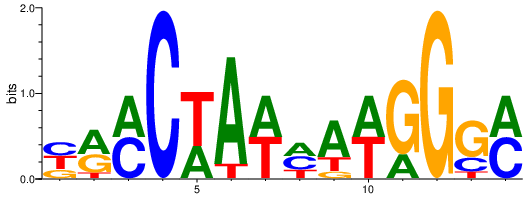

In [8]:
import seqlogo
#make seqlogo PWM object
seq_pwm = seqlogo.Pwm(pwm)
# Convert to ppm needed for plotting
seq_ppm = seqlogo.Ppm(seqlogo.pwm2ppm(seq_pwm))
seqlogo.seqlogo(seq_ppm, ic_scale = True, format = 'png', size = 'medium')

## 3. Using PWMs for scoring motif matches

Now that we have our PWM, we can use it to score a new sequence to see how well it matches our given motif. We can compute the score of a sequence $s$ as:

$$ Score(s) = \sum_{i=1}^n PWM[s_i,i] $$

where $s_i$ is the nucleotide in sequence $s$ at position $i$ (which we are encoding here as A=0, C=1, G=2, T=3).

This score is equivalent to:
$$ Score(s) = \sum_{i=1}^n log_2 \frac{p(s_i,i)}{p(s_i)} = log_2 \left( \frac{p(s_0,0)p(s_1,1) ... p(s_n,n)}{p(s_1)p(s_2)...p(s_n)}\right) $$

or, the log2 ratio of the probability to see this sequence given it was generated by our motif vs. the probabilitly to see this sequence given that it was generated from random genomic sequence. Visually, we are just adding up scores of the cells of the PWM that match our sequence. So if we saw a sequence "GACCAAATAAGGCA" we could compute its score by walking it through our PWM and adding up the values in each cell:


$$
\begin{array}{| c | c |c |c| c| c |c |c |c |c |c |c |c |c |c |c |}
\hline
obs. seq: & G & A & C & C & A & A & A & T & A & A & G & G & C & A \\
\hline
A & -1.6&\textbf{0.7}&0.7&-1.6&\textbf{0.4}&\textbf{1.4}&\textbf{0.7}&0.4&\textbf{1.0}&\textbf{0.7}&0.0&-1.6&-1.6&\textbf{0.7}\\
C & 0.4&-1.6&\textbf{0.7}&\textbf{1.6}&-1.6&-1.6&-1.6&0.4&-1.6&-1.6&-1.6&-1.6&\textbf{0.0}&0.7\\
G & \textbf{0.0}&0.4&-1.6&-1.6&-1.6&-1.6&-1.6&-1.6&-0.6&-1.6&\textbf{1.2}&\textbf{1.6}&1.0&-1.6\\
T & 0.4&-0.6&-1.6&-1.6&1.0&-0.6&0.7&\textbf{0.0}&0.0&0.7&-1.6&-1.6&-0.6&-1.6\\
\hline
\end{array}
$$

$$ Score(GACCAAATAAGGCA) = 0+0.7+0.7+1.6+0.4+1.4+0.7+0.0+1.0+0.7+1.2+1.6+0+0.7 \approx 10.7$$
(this might differ a bit from your answer below due to round off error).

**Question 3 (2 pts)**: Complete the function `ScoreSeq` below to score a sequence based on given PWM.

In [12]:
def ScoreSeq(pwm, sequence):
    """ Score a sequence using a PWM
    
    Parameters
    ----------
    pwm : 2d np.array
       Position weight matrix
    sequence : str
       Sequence of nucleotides to be scored
       
    Returns
    -------
    score : float
       PWM score of the sequence
    """
    score = 0
    # your code here
    for i in range(len(sequence)):
        if sequence[i]=='A':
            score+=pwm[0][i]
        elif sequence[i]=='C':
            score+=pwm[1][i]
        elif sequence[i]=='G':
            score+=pwm[2][i]
        elif sequence[i]=='T':
            score+=pwm[3][i]
    return score

score = ScoreSeq(pwm, "GACCAAATAAGGCA")
score

14.253818678800526

In [13]:
"""Test output of ScoreSeq"""
# testing on a different PWM incase the computed one was wrong
test_pwm = np.array([[1, 0, 0, 0], [0, -1, 1, 1], [2, -4, 0, 6], [1, -2, 1, 0]]).transpose()
test_sequence = "GTAT"
assert(ScoreSeq(test_pwm, test_sequence)==3)

## 4. Setting the threshold

A score of ~14 sounds pretty good! But how do we know how high of a score we should be looking for to know if a match is good? One way is to look at a bunch of scores of random sequences to see what non-matches look like. 

Thinking in p-value language, our null hypothesis is that a sequence wasn't generated by the motif (PWM). Our test statistic is the PWM score. "Null" data is just random sequences. Then we can get a p-value for a match by seeing what fraction of "null" (random) sequences score better than it.

**Question 4 (2 pts)**: The code below generates a null distribution of PWM scores by generating a bunch of random sequences. Complete the function `GetThreshold` which computes the score threshold required to obtain a given p-value. The code plots the null distribution and where your threshold falls for p-value of 0.01. (Hint, it should fall pretty far to the right of the plot).

Populating the interactive namespace from numpy and matplotlib


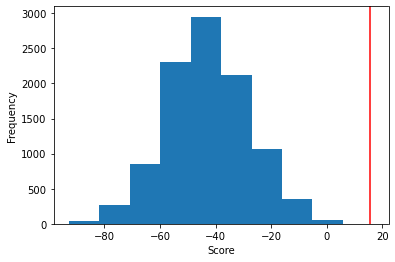

In [17]:
%pylab inline

def RandomSequence(n):
    """ Generate a random string of nucleotides of length n
    
    Parameters
    ----------
    n : int
       Length of random string to generate
       
    Returns
    -------
    seq : str
       Random nucleotide string
    """
    seq = ""
    for i in range(n):
        seq += ["A","C","G","T"][random.randint(4)]
    return seq

def GetThreshold(null_dist, pval):
    """ Find the threshold to achieve a desired p-value
    
    Given a null distribution (list of values),
    find the threshold to achieve a desired p-value
    
    Parameters
    ----------
    null_dist : list of float
       Null distribution of scores
    pval : float
       % of null_dist that should be above the threshold returned
       
    Returns
    -------
    thresh : float
       Threshold to achieve the desired p-value    
    """
    thresh = 0 # set this  below to be the score threshold to obtain a p-value <0.01
    null_dist.sort()
    rangeNum = null_dist[-1]-null_dist[0]
    thresh = null_dist[-1]-rangeNum*pval
    return thresh

numsim = 10000
null_scores = [ScoreSeq(pwm, RandomSequence(14)) for i in range(numsim)]
thresh = GetThreshold(null_scores, 0.01)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(null_scores, bins=10);
ax.axvline(x=thresh, color="red")
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

In [18]:
"""Test value of thresh"""
null_dist = [i for i in range(0, 101)]
assert(GetThreshold(null_dist, 0.05)==95)
assert(GetThreshold(null_dist, 0.01)==99)

## 5. Scanning sequences for motif matches using PWMs

Now that we have our scoring function, we can scan a long sequence of DNA for matches to find potential binding sites for our factor. We can do this by computing the score of each possible length $n$ substring of our sequence and finding top hits.

**Question 5 (2 pts)**: Complete the function `ScanSequence` below, which scans a sequence of DNA for matches to our PWM. The code will plot your scores across the sequence. You should see two top matches for your PWM!

Populating the interactive namespace from numpy and matplotlib


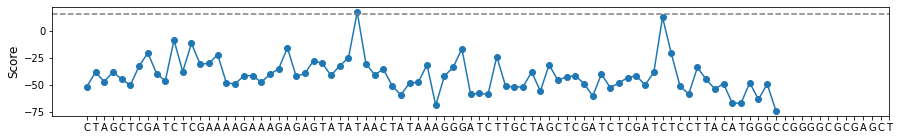

In [22]:
%pylab inline
nucs = {"A": 0, "C": 1, "G": 2, "T": 3} # this might be helpful

def ScanSequence(pwm, sequence):
    """ Scan a sequence using a PWM
    
    Parameters
    ----------
    pwm : 2d np.array
        PWM matrix
    sequence : str
        Long nucleotide string
        
    Returns
    -------
    scores : list of float
        scores[i] should give the score of the substring sequence[i:i+n]
    """
    n = pwm.shape[1]
    scores = [0]*(len(sequence)-n+1) # list of scores. scores[i] should give the score of the substring sequence[i:i+n]
    for a in range(len(sequence)-n+1):
        s = sequence[a:a+n]
        score = 0
        for i in range(len(s)):
            if s[i]=='A':
                score+=pwm[0][i]
            elif s[i]=='C':
                score+=pwm[1][i]
            elif s[i]=='G':
                score+=pwm[2][i]
            elif s[i]=='T':
                score+=pwm[3][i]
        scores[a]=score 
    return scores

binding_sites = [
    "GACCAAATAAGGCA",
    "GACCAAATAAGGCA",
    "TGACTATAAAAGGA",
    "TGACTATAAAAGGA",
    "TGCCAAAAGTGGTC",
    "CAACTATCTTGGGC",
    "CAACTATCTTGGGC",
    "CTCCTTACATGGGC"
]
seq = "CTAGCTCGATCTCGAAAAGAAAGAGAGTATATAACTATAAAGGGATCTTGCTAGCTCGATCTCGATCTCCTTACATGGGCCGGGGCGCGAGCT"
pwm = GetPWM(binding_sites)
scores = ScanSequence(pwm, seq)

# Plot them to see where in the sequence any matches start
fig = plt.figure()
fig.set_size_inches((15, 2))
ax = fig.add_subplot(111)
ax.plot(range(len(seq)), scores + [None]*(pwm.shape[1]-1), marker="o")
ax.axhline(y=thresh, color="gray", linestyle="dashed")
ax.set_xticks(range(len(seq)))
ax.set_xticklabels(list(seq));
ax.set_ylabel("Score", size=12);

In [23]:
"""Test output of ScanSequence"""
test_pwm = np.array([[1, 0, 0, 0], [0, -1, 1, 1], [2, -4, 0, 6], [1, -2, 1, 0]]).transpose()
test_sequence = "GTATGTAT"
test_scores = ScanSequence(test_pwm, test_sequence)
assert(list(test_scores) == [3,7,2,8,3])

Look at the sequences starting at the top scoring positions. Do they seem to match the sequence logo we generated for this PWM above?

## 6. Limitations of PWMs

Overall, PWMs are a nice tool for motif finding. They work far better than looking for exact matches to a "consensus" sequence. However, there are several important limitations to keep in mind:

* How will PWMs deal with insertions or deletions within a sequence that otherwise matches the motif?
* PWMs assume no dependence between bases. Can you imagine a situation when that's not true?
* Scores are heavily dependent on the background nucleotide frequencies. It is a good idea in practice to compute those from background sequences rather than using 25% for each nucleotide like we did here.

In this week's lab, we'll do some motif finding on real data using Homer. The next exercise will continue with motifs, focusing on detecting which motifs are enriched in a set of bound sequences.